In [223]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import transforms
import random
import os
from PIL import Image
import torchvision.transforms.functional as F

# Model

In [203]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm1 = nn.InstanceNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.norm2 = nn.InstanceNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu(out)

        #out += residual  # Add the residual
        return out

        # "residual_blocks.conv1.weight", "residual_blocks.conv1.bias", "residual_blocks.conv2.weight", "residual_blocks.conv2.bias"

In [204]:
class AdvancedStyleTransferModel(nn.Module):
    def __init__(self):
        super(AdvancedStyleTransferModel, self).__init__()

        # Initial convolution input image size=3x64x64
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=2)  # 32x64x64
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(32, 128, kernel_size=2, stride=1, padding=1)  # 128x32x32
        self.relu2 = nn.ReLU()
    

        self.conv_transpose1 = nn.ConvTranspose2d(128, 32, kernel_size=2, stride=1, padding=1)  # 32x64x64
        self.relu3 = nn.ReLU()

        self.conv_transpose2 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=1, padding=2)
        self.relu4 = nn.ReLU()
        
        # Residual blocks
        self.residual_blocks = ResidualBlock(32, 32)
                                        
        
        

    def forward(self, x):
        resu = x
        out = self.relu1(self.conv1(x))
        #out = self.batch_norm1(out)
        out = self.residual_blocks(out)
        out = self.relu2(self.conv2(out))
        #out = self.batch_norm2(out)
        #out = self.residual_blocks(out)
        out = self.relu3(self.conv_transpose1(out))
        out = self.conv_transpose2(out)
        #out = self.batch_norm2(out)
        # out += resu
        return out

# Loading Model

In [205]:
model_url=r'models\model_final_train_loss_0.1172_val_loss_0.1181.pth'
test_folder_path=r'dataset\test'

In [229]:
model_dict = torch.load(model_url, map_location=torch.device('cpu'))
model = AdvancedStyleTransferModel()
model.load_state_dict(model_dict)

<All keys matched successfully>

# Loading image

In [216]:
mean = [0.485, 0.456, 0.406]  # RGB mean values
std = [0.229, 0.224, 0.225]
normalize=transforms.Normalize(
    mean=mean, std=std
)

In [217]:
def de_norm(img):
  denormalize = transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])
  return denormalize(img)

In [218]:
transform_test=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    normalize
])

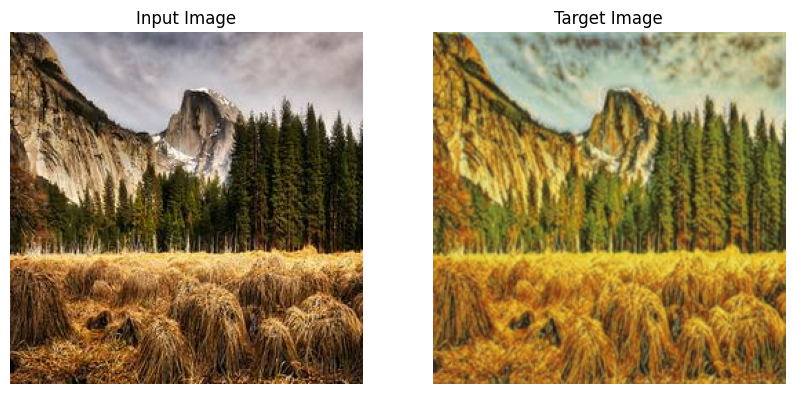

In [228]:
sample_image_name =random.choice(os.listdir(test_folder_path))
image_url = os.path.join(test_folder_path, sample_image_name)
test_image=Image.open(image_url).convert('RGB')
test_image=transform_test(test_image)
output_image = model(test_image)
test_image=de_norm(test_image)
output_image=de_norm(output_image)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
test_input=F.to_pil_image(test_image.squeeze(0)).convert('RGB')
test_output_img = transforms.ToPILImage()(output_image.squeeze(0).clamp(0, 1))


axes[0].imshow(test_input)
axes[0].axis('off')
axes[0].set_title('Input Image')


axes[1].imshow(test_output_img)
axes[1].axis('off')
axes[1].set_title('Target Image')

plt.show()
